# Algorithm

```Python
def extract_data():
    1. Read image
    2. Get Face ROI
    3. Get ROI for eyes and mouth
    4. Get landmark coordinates (eyes and mouth)
    5. Calculate EAR (Eye Aspect Ratio) & MAR (Mouth Aspect Ratio)

def generate_data():
    1. Loop through folder
    2. Extract data and store as one row with specified time frame (2 seconds or 60 frames)

def train():
    1. Split data
    2. Create LSTM model
    3. Train and validate
    4. Test model

def create_report():
    1. Calculate accuracy, precision, recall, and F1 score for train, validation, and test sets
    2. Support with visualizations


In [91]:

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pprint import pprint
import random

import mediapipe as mp
import tensorflow as tf
import pandas as pd

In [2]:
# # MEDIAPIPE FACEMESH LANDMARK GUIDELINES

# // Lips.
# 61, 146, 146, 91, 91, 181, 181, 84, 84, 17, 17, 314, 314, 405, 405, 321,
# 321, 375, 375, 291, 61, 185, 185, 40, 40, 39, 39, 37, 37, 0, 0, 267, 267,
# 269, 269, 270, 270, 409, 409, 291, 78, 95, 95, 88, 88, 178, 178, 87, 87, 14,
# 14, 317, 317, 402, 402, 318, 318, 324, 324, 308, 78, 191, 191, 80, 80, 81,
# 81, 82, 82, 13, 13, 312, 312, 311, 311, 310, 310, 415, 415, 308,
# // Left eye.
# 33, 7, 7, 163, 163, 144, 144, 145, 145, 153, 153, 154, 154, 155, 155, 133,
# 33, 246, 246, 161, 161, 160, 160, 159, 159, 158, 158, 157, 157, 173, 173,
# 133,
# // Left eyebrow.
# 46, 53, 53, 52, 52, 65, 65, 55, 70, 63, 63, 105, 105, 66, 66, 107,
# // Left iris.
# 474, 475, 475, 476, 476, 477, 477, 474,
# // Right eye.
# 263, 249, 249, 390, 390, 373, 373, 374, 374, 380, 380, 381, 381, 382, 382,
# 362, 263, 466, 466, 388, 388, 387, 387, 386, 386, 385, 385, 384, 384, 398,
# 398, 362,
# // Right eyebrow.
# 276, 283, 283, 282, 282, 295, 295, 285, 300, 293, 293, 334, 334, 296, 296,
# 336,
# // Right iris.
# 469, 470, 470, 471, 471, 472, 472, 469,
# // Face oval.
# 10, 338, 338, 297, 297, 332, 332, 284, 284, 251, 251, 389, 389, 356, 356,
# 454, 454, 323, 323, 361, 361, 288, 288, 397, 397, 365, 365, 379, 379, 378,
# 378, 400, 400, 377, 377, 152, 152, 148, 148, 176, 176, 149, 149, 150, 150,
# 136, 136, 172, 172, 58, 58, 132, 132, 93, 93, 234, 234, 127, 127, 162, 162,
# 21, 21, 54, 54, 103, 103, 67, 67, 109, 109, 10};

In [3]:
# Inisialisasi Face Detection dari MediaPipe
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

IMG_SIZE = (116, 116)

# A. Extract Data

## 1. Read Image

- Resize to 116x116

In [4]:
# def read_images_from_folder(folder_path, img_size=IMG_SIZE):
#     """
#     Fungsi untuk membaca semua gambar dari folder tertentu dan mengembalikannya sebagai array.
#     Args:
#     - folder_path (str): Path folder berisi gambar.
#     - img_size (tuple): Ukuran gambar yang diinginkan (width, height).
    
#     Returns:
#     - images (list of tensors): Daftar tensor gambar yang sudah diubah ukurannya.
#     """
#     image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
#     images = []
    
#     for img_path in image_paths:
#         img = tf.io.read_file(img_path)
#         img = tf.image.decode_image(img, channels=3)
#         img = tf.image.resize(img, img_size)
#         images.append(img.numpy())  # Mengonversi tensor ke numpy array untuk penggunaan lebih lanjut
    
#     return images

# def display_images(images, num_images=5):
#     """
#     Fungsi untuk menampilkan beberapa gambar dari array menggunakan matplotlib.
#     Args:
#     - images (list of arrays): Daftar gambar dalam bentuk array.
#     - num_images (int): Jumlah gambar yang ingin ditampilkan.
#     """
#     plt.figure(figsize=(15, 15))
#     for i in range(min(num_images, len(images))):
#         plt.subplot(1, num_images, i + 1)
#         plt.imshow(images[i].astype("uint8"))
#         plt.axis("off")
#     plt.show()
    
def read_image(image_path, img_size=IMG_SIZE, resize=False):
    """
    Fungsi untuk membaca satu gambar menggunakan OpenCV dan mengembalikannya sebagai array.
    Args:
    - image_path (str): Path gambar.
    - img_size (tuple): Ukuran gambar yang diinginkan (width, height).
    
    Returns:
    - image (numpy array): Gambar yang sudah diubah ukurannya sebagai array.
    """
    img = cv2.imread(image_path)             # Membaca gambar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Mengubah format dari BGR (default OpenCV) ke RGB
    if resize:
        img = cv2.resize(img, img_size)          # Mengubah ukuran gambar sesuai img_size
    # print(img.shape)
    return img  # Mengembalikan sebagai array numpy

def display_image(image, title=None, landmarks=None, display=None):
    """
    Fungsi untuk menampilkan satu gambar menggunakan matplotlib dengan opsi menambahkan judul dan landmark.
    Args:
    - image (numpy array): Gambar dalam bentuk array.
    - title (str, optional): Judul yang akan ditampilkan di atas gambar.
    - landmarks (list of tuples, optional): Daftar koordinat landmark yang akan ditampilkan pada gambar.
    """
    plt.imshow(image.astype("uint8"))
    if landmarks:
        for i, (x, y) in enumerate(landmarks):
            plt.plot(x, y, 'ro')  # Tampilkan landmark sebagai titik merah
            if display:
                plt.text(x, y, f'p{i+1}', color="yellow", fontsize=8, ha="center")  # Tambahkan label
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

    
# folder_path = "../../Datasets/NTHU-DDD/drowsy/001_glasses_sleepyCombination_599_drowsy.jpg"
# images = read_images_from_folder(folder_path)
# display_images(images, num_images=5)

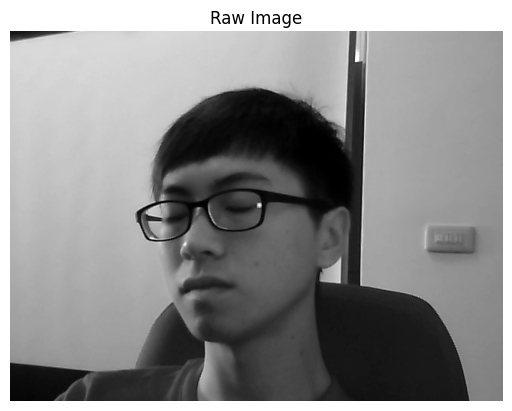

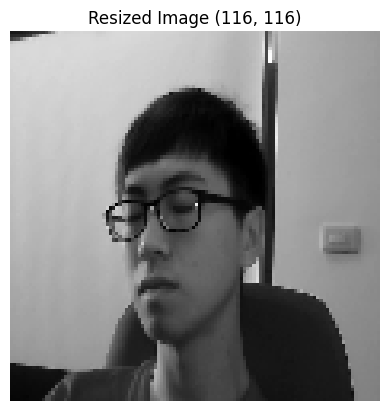

In [86]:
raw = dict()
rsz = dict()

# Contoh Gambar yang Noding gagal didedteksi wajahnya
# file_path = "../../Datasets/NTHU-DDD/train/drowsy/001_glasses_sleepyCombination_1689_drowsy.jpg"
file_path = "../../Datasets/NTHU-DDD/train/drowsy/001_glasses_sleepyCombination_1082_drowsy.jpg"
# file_path = "../../Datasets/NTHU-DDD/drowsy/006_glasses_slowBlinkWithNodding_499_drowsy.jpg"

raw['img'] = read_image(file_path, resize=False)
display_image(raw['img'], "Raw Image")

rsz['img'] = read_image(file_path, resize=True)
display_image(rsz['img'], f"Resized Image {IMG_SIZE}")

## 2. Get Face ROI

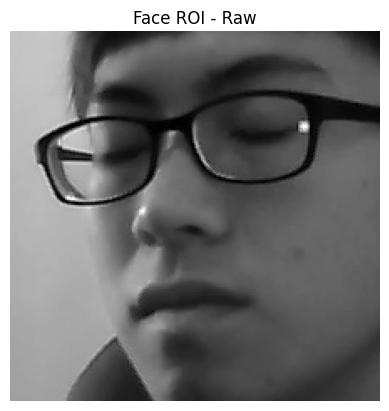

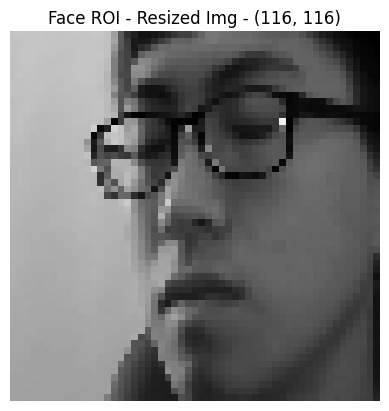

In [56]:
def get_face_roi_mediapipe(image):
    """
    Fungsi untuk mendeteksi satu wajah dan mengembalikan ROI wajah dari gambar menggunakan MediaPipe.
    Args:
    - image (numpy array): Gambar dalam bentuk array.
    
    Returns:
    - face_roi (array): ROI wajah yang terdeteksi, atau None jika tidak ada wajah terdeteksi.
    """
    face_roi = None
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Konversi gambar ke RGB karena MediaPipe menggunakan RGB
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.detections:
            # Ambil bounding box dari wajah pertama yang terdeteksi
            detection = results.detections[0]
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
            
            # Ekstrak ROI wajah berdasarkan bounding box
            face_roi = image[y:y+h, x:x+w]
                
    return face_roi


raw['face_roi'] = get_face_roi_mediapipe(raw['img'])  # Menggunakan variabel `img` yang sudah ada
display_image(raw['face_roi'], "Face ROI - Raw")

rsz['face_roi'] = get_face_roi_mediapipe(rsz['img'])  # Menggunakan variabel `img` yang sudah ada
display_image(rsz['face_roi'], f"Face ROI - Resized Img - {IMG_SIZE}")

## 3. Get Eyes and Mouth ROI

In [7]:
def get_eye_and_mouth_roi(image, tolerance=0.15):
    """
    Fungsi untuk mendeteksi ROI mata (garis kepala) dan mulut menggunakan MediaPipe,
    dengan memastikan ROI memiliki orientasi landscape dan menambahkan toleransi yang
    dapat diatur pada ukuran ROI agar tidak terlalu presisi.
    
    Args:
    - image (numpy array): Gambar dalam bentuk array.
    - tolerance (float): Persentase tambahan ukuran ROI (default: 0.15 atau 15%).
    
    Returns:
    - eye_roi (array): ROI untuk area mata atau None jika tidak terdeteksi.
    - mouth_roi (array): ROI untuk area mulut atau None jika tidak terdeteksi.
    - eye_roi_coords (tuple): Koordinat (x, y, width, height) untuk ROI mata.
    - mouth_roi_coords (tuple): Koordinat (x, y, width, height) untuk ROI mulut.
    """
    eye_roi, mouth_roi = None, None
    eye_roi_coords, mouth_roi_coords = None, None
    
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        # Konversi gambar ke RGB, karena MediaPipe menggunakan RGB
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks:
            # Ambil landmark wajah pertama yang terdeteksi
            face_landmarks = results.multi_face_landmarks[0]
            ih, iw, _ = image.shape
            
            # Landmark koordinat untuk mata (landmark 33 dan 263 untuk garis sekitar mata kiri dan kanan)
            left_eye_x = int(face_landmarks.landmark[33].x * iw)
            left_eye_y = int(face_landmarks.landmark[33].y * ih)
            right_eye_x = int(face_landmarks.landmark[263].x * iw)
            
            # Buat ROI mata sebagai area yang lebih lebar (landscape)
            eye_roi_width = abs(right_eye_x - left_eye_x) + 40  # Tambahkan toleransi lebar
            eye_roi_height = eye_roi_width // 2  # Pastikan lebar lebih besar dari tinggi (landscape)
            
            # Tambahkan toleransi pada ukuran ROI
            eye_roi_width = int(eye_roi_width * (1 + tolerance))
            eye_roi_height = int(eye_roi_height * (1 + tolerance))
            
            y_eye_top = max(0, left_eye_y - eye_roi_height // 2)
            x_eye_left = max(0, left_eye_x - 20)
            eye_roi = image[y_eye_top:y_eye_top + eye_roi_height, x_eye_left:x_eye_left + eye_roi_width]
            eye_roi_coords = (x_eye_left, y_eye_top, eye_roi_width, eye_roi_height)

            # Landmark koordinat untuk mulut (landmark 13 dan 14 untuk bagian atas dan bawah mulut)
            mouth_top_y = int(face_landmarks.landmark[13].y * ih)
            mouth_bottom_y = int(face_landmarks.landmark[14].y * ih)
            
            # Hitung tinggi kepala untuk orientasi landscape pada ROI mulut
            forehead_y = int(face_landmarks.landmark[10].y * ih)
            chin_y = int(face_landmarks.landmark[152].y * ih)
            head_height = abs(chin_y - forehead_y)
            
            # Buat ROI mulut dengan orientasi landscape
            mouth_roi_height = min(max(int(head_height * 0.25), abs(mouth_bottom_y - mouth_top_y)), int(head_height * 0.5))
            mouth_roi_width = mouth_roi_height * 2  # Set lebar lebih besar dari tinggi
            
            # Tambahkan toleransi pada ukuran ROI
            mouth_roi_width = int(mouth_roi_width * (1 + tolerance))
            mouth_roi_height = int(mouth_roi_height * (1 + tolerance))
            
            y_mouth_top = max(0, mouth_top_y - mouth_roi_height // 2)
            x_mouth_left = max(0, int(face_landmarks.landmark[61].x * iw) - 10)
            mouth_roi = image[y_mouth_top:y_mouth_top + mouth_roi_height, x_mouth_left:x_mouth_left + mouth_roi_width]
            mouth_roi_coords = (x_mouth_left, y_mouth_top, mouth_roi_width, mouth_roi_height)
                
    return eye_roi, eye_roi_coords, mouth_roi, mouth_roi_coords


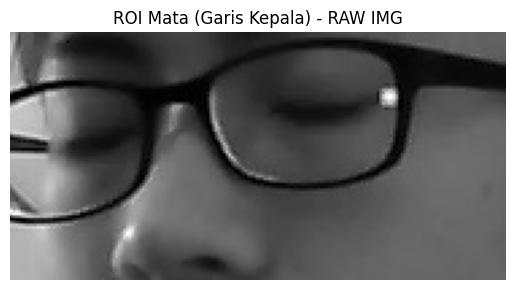

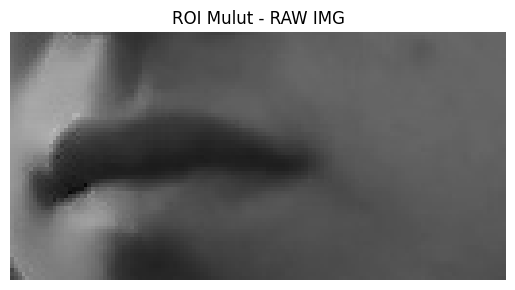

In [8]:
# raw['eye_roi'], raw['eye_roi_coords'], raw['mouth_roi'], raw['mouth_roi_coords'] = get_eye_and_mouth_roi(raw['face_roi'])
raw['eye_roi'], raw['eye_roi_coords'], raw['mouth_roi'], raw['mouth_roi_coords'] = get_eye_and_mouth_roi(raw['img'])
  
display_image(raw['eye_roi'], title=f"ROI Mata (Garis Kepala) - RAW IMG") if raw['eye_roi'] is not None else print("Mata tidak terdeteksi.")
display_image(raw['mouth_roi'], title=f"ROI Mulut - RAW IMG") if raw['mouth_roi'] is not None else print("Mulut tidak terdeteksi.")

In [9]:
rsz['eye_roi'], rsz['eye_roi_coords'], rsz['mouth_roi'], rsz['mouth_roi_coords'] = get_eye_and_mouth_roi(rsz['face_roi'])
  
display_image(rsz['eye_roi'], title=f"ROI Mata (Garis Kepala) - {IMG_SIZE} IMG") if rsz['eye_roi'] is not None else print("Mata tidak terdeteksi.")
display_image(rsz['mouth_roi'], title=f"ROI Mulut - {IMG_SIZE} IMG") if rsz['mouth_roi'] is not None else print("Mulut tidak terdeteksi.")

Mata tidak terdeteksi.
Mulut tidak terdeteksi.


## 4. Get Landmark Coordinates (Eyes and Mouth)

In [10]:
def get_landmarks_for_aspect_ratio(image, eye_roi_coords, mouth_roi_coords):
    """
    Fungsi untuk mendapatkan koordinat 6 landmark untuk masing-masing mata (kiri dan kanan) dan 
    6 landmark mulut relatif terhadap ROI untuk perhitungan EAR dan MAR.
    Args:
    - image (numpy array): Gambar asli dalam bentuk array.
    - eye_roi_coords (tuple): Koordinat (x, y, width, height) dari ROI mata.
    - mouth_roi_coords (tuple): Koordinat (x, y, width, height) dari ROI mulut.
    
    Returns:
    - left_eye_landmarks (list): 6 koordinat landmark mata kiri relatif terhadap ROI mata kiri.
    - right_eye_landmarks (list): 6 koordinat landmark mata kanan relatif terhadap ROI mata kanan.
    - mouth_landmarks (list): 6 koordinat landmark mulut relatif terhadap ROI mulut.
    """
    left_eye_landmarks, right_eye_landmarks, mouth_landmarks = [], [], []

    # Landmark ID untuk mata kiri, mata kanan, dan mulut    
    chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
    chosen_right_eye_idxs = [33, 160, 158, 133, 153, 144]
    chosen_mouth_idxs = [76, 38, 13, 268, 292, 316, 14, 86]

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        # Konversi gambar ke RGB, karena MediaPipe menggunakan RGB
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks:
            # Ambil landmark wajah pertama yang terdeteksi
            face_landmarks = results.multi_face_landmarks[0]
            ih, iw, _ = image.shape

            # Koordinat untuk ROI mata kiri
            x_left_eye, y_left_eye, left_eye_width, left_eye_height = eye_roi_coords
            left_eye_landmarks = [
                (int((face_landmarks.landmark[idx].x * iw) - x_left_eye), int((face_landmarks.landmark[idx].y * ih) - y_left_eye))
                for idx in chosen_left_eye_idxs
            ]

            # Koordinat untuk ROI mata kanan
            x_right_eye, y_right_eye, right_eye_width, right_eye_height = eye_roi_coords
            right_eye_landmarks = [
                (int((face_landmarks.landmark[idx].x * iw) - x_right_eye), int((face_landmarks.landmark[idx].y * ih) - y_right_eye))
                for idx in chosen_right_eye_idxs
            ]

            # Koordinat untuk ROI mulut
            x_mouth_left, y_mouth_top, mouth_roi_width, mouth_roi_height = mouth_roi_coords
            mouth_landmarks = [
                (int((face_landmarks.landmark[idx].x * iw) - x_mouth_left), int((face_landmarks.landmark[idx].y * ih) - y_mouth_top))
                for idx in chosen_mouth_idxs
            ]
                
    return left_eye_landmarks, right_eye_landmarks, mouth_landmarks

c:\Users\whisn\anaconda3\envs\bangkitcourse\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


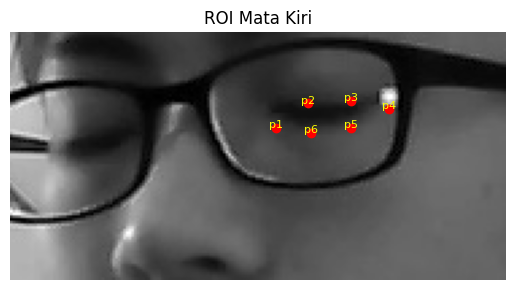

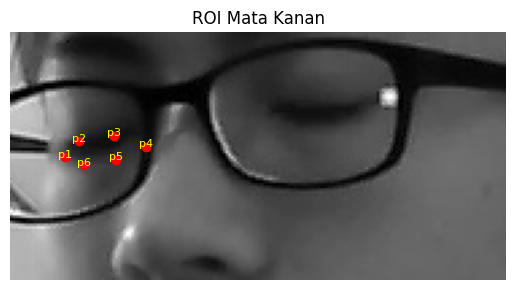

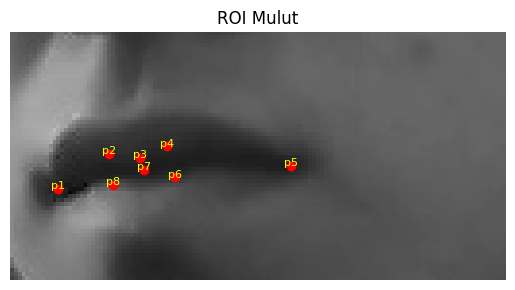

In [11]:
raw['left_eye_landmarks'], raw['right_eye_landmarks'], raw['mouth_landmarks'] = get_landmarks_for_aspect_ratio(raw['img'], raw['eye_roi_coords'], raw['mouth_roi_coords'])
# raw['left_eye_landmarks'], raw['right_eye_landmarks'], raw['mouth_landmarks'] = get_landmarks_for_aspect_ratio(raw['face_roi'], raw['eye_roi_coords'], raw['mouth_roi_coords'])

# Menampilkan ROI dan landmark masing-masing
display_image(raw['eye_roi'], title="ROI Mata Kiri", landmarks=raw['left_eye_landmarks'], display=True)
display_image(raw['eye_roi'], title="ROI Mata Kanan", landmarks=raw['right_eye_landmarks'], display=True)
display_image(raw['mouth_roi'], title="ROI Mulut", landmarks=raw['mouth_landmarks'], display=True)

## 5. Calculate MAR and EAR

In [12]:
def calculate_ear(left_eye_landmarks, right_eye_landmarks):
    """
    Menghitung Eye Aspect Ratio (EAR) berdasarkan landmark mata kiri dan mata kanan.
    
    Args:
    - left_eye_landmarks (list of tuples): Daftar koordinat (x, y) untuk mata kiri.
    - right_eye_landmarks (list of tuples): Daftar koordinat (x, y) untuk mata kanan.
    
    Returns:
    - ear_left (float): Nilai EAR untuk mata kiri.
    - ear_right (float): Nilai EAR untuk mata kanan.
    """
    def ear_single_eye(eye_landmarks):
        # Menghitung EAR untuk satu mata
        p1, p2, p3, p4, p5, p6 = eye_landmarks
        vertical_1 = np.linalg.norm(np.array(p2) - np.array(p5))
        vertical_2 = np.linalg.norm(np.array(p3) - np.array(p6))
        horizontal = np.linalg.norm(np.array(p1) - np.array(p4))
        ear = (vertical_1 + vertical_2) / (2.0 * horizontal)
        return ear

    # EAR untuk mata kiri dan mata kanan
    ear_left = ear_single_eye(left_eye_landmarks)
    ear_right = ear_single_eye(right_eye_landmarks)
    avg_ear = (ear_left + ear_right) / 2
    return ear_left, ear_right, avg_ear


def calculate_mar(mouth_landmarks):
    """
    Menghitung Mouth Aspect Ratio (MAR) berdasarkan landmark mulut.
    
    Args:
    - mouth_landmarks (list of tuples): Daftar koordinat (x, y) untuk mulut.
    
    Returns:
    - mar (float): Nilai MAR untuk mulut.
    """
    # Mengambil koordinat titik-titik yang sesuai dari landmark mulut
    p1, p2, p3, p4, p5, p6, p7, p8 = mouth_landmarks
    vertical_1 = np.linalg.norm(np.array(p2) - np.array(p8))
    vertical_2 = np.linalg.norm(np.array(p3) - np.array(p7))
    horizontal = np.linalg.norm(np.array(p1) - np.array(p5))
    mar = (vertical_1 + vertical_2) / (2.0 * horizontal)
    return mar


In [13]:
mar = calculate_mar(raw['mouth_landmarks'])
# ear_left, ear_right = calculate_ear(raw['left_eye_landmarks'], raw['right_eye_landmarks'])
ear = calculate_ear(raw['left_eye_landmarks'], raw['right_eye_landmarks'])

print(f"{mar}\n{ear}")

0.09307358478544556
(0.44114040379167013, 0.5155843019312233, 0.4783623528614467)


## Create Function Ectract Image

In [37]:
def extract_image(image_path, img_size=IMG_SIZE, resize=False):
    """
    Membaca gambar, mendeteksi ROI wajah, mata, dan mulut, dan menghitung EAR serta MAR.
    
    Args:
    - image_path (str): Path gambar.
    - img_size (tuple): Ukuran gambar yang diinginkan (width, height).
    - resize (bool): Jika True, gambar akan diubah ukurannya.
    
    Returns:
    - dict: Berisi nilai EAR, MAR, dan landmark untuk mata dan mulut.
    """
    # Menggunakan fungsi read_image untuk membaca gambar
    img = read_image(image_path, img_size=img_size, resize=resize)
    
    # Menggunakan fungsi get_face_roi_mediapipe untuk mendeteksi wajah
    face_roi = get_face_roi_mediapipe(img)
    # Deteksi ROI mata dan mulut
    eye_roi, eye_roi_coords, mouth_roi, mouth_roi_coords = get_eye_and_mouth_roi(face_roi)
    
    # Jika tidak ada ROI mata atau mulut, kembalikan None
    used_img = img
    if eye_roi is None or mouth_roi is None:
        eye_roi, eye_roi_coords, mouth_roi, mouth_roi_coords = get_eye_and_mouth_roi(used_img)
    else:
        used_img = face_roi
    
    # Mendapatkan landmark untuk EAR dan MAR
    left_eye_landmarks, right_eye_landmarks, mouth_landmarks = get_landmarks_for_aspect_ratio(used_img, eye_roi_coords, mouth_roi_coords)
    
    # Menghitung EAR
    ear_left, ear_right, avg_ear = calculate_ear(left_eye_landmarks, right_eye_landmarks)
    
    # Menghitung MAR
    mar = calculate_mar(mouth_landmarks)
    
    # Mengembalikan hasil sebagai dictionary
    result =  {
        'ear_left': ear_left,
        'ear_right': ear_right,
        'avg_ear': avg_ear,
        'mar': mar,
        'left_eye_landmarks': left_eye_landmarks,
        'right_eye_landmarks': right_eye_landmarks,
        'mouth_landmarks': mouth_landmarks
    }
    
    # pprint(result, sort_dicts=False)
    
    return result


In [15]:
hasil = extract_image(file_path)
print(hasil['avg_ear'])

0.4783623528614467


# B. Generate Data

Make sure that processing at 2 seconds per 60 frames is only applied to a single subject

In [16]:
def iterate_folder(data_dir):
    """
    Menelusuri semua subfolder dalam `data_dir` dan mencetak nama file serta path lengkap untuk setiap gambar.
    
    Args:
    - data_dir (str): Direktori utama yang berisi folder dan subfolder gambar.
    """
    subjects = {
        'count' : [],
        'name' : []
    }
    subject_counts = 0
    # Loop melalui seluruh folder, subfolder, dan file di dalam direktori utama
    for root, dirs, files in os.walk(data_dir):
        frame = 0
        for file in files:
            label = root.split('\\')[-1]
            # Periksa apakah file tersebut adalah gambar
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Sesuaikan format gambar jika perlu
                full_path = os.path.join(root, file)
                # print(f"Image: {file}\nPath: {full_path}\n")
                subject = file.split("_")[0]
                # print(subject)
                temp = []
                temp.append(subject)
                
                if frame <= 60:
                    frame += 1   
                elif frame > 60:
                    frame = 0
                    subject_counts += 1
                    subjects['name'].append(set(temp))
                    subjects['count'].append(subject_counts)
                    
    # pprint(subjects)
    return subjects
                

In [17]:
res = iterate_folder("../../Datasets/NTHU-DDD/drowsy")
res_df = pd.DataFrame(res)
res_df['name'].astype(str).value_counts()

name
{'005'}    211
{'002'}    171
{'001'}    154
{'006'}     45
Name: count, dtype: int64

In [73]:
def generate_data(data_dir):
    """
    Menelusuri semua subfolder dalam `data_dir` dan mencetak nama file serta path lengkap untuk setiap gambar.
    
    Args:
    - data_dir (str): Direktori utama yang berisi folder dan subfolder gambar.
    """
    rows = []
    count = 0
    data_not_detected = 0 
    last_processed_file = None  # Menyimpan file terakhir yang diproses
    error_files = []

    for root, dirs, files in os.walk(data_dir):
        frame = 0
        row = {}
        for file in files:
            label = root.split('\\')[-1]
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Sesuaikan format gambar jika perlu
                full_path = os.path.join(root, file)
                last_processed_file = full_path  # Update file terakhir yang diproses
                try:
                    res = extract_image(full_path)
                    if res is not None and 'mar' in res and 'avg_ear' in res:
                        if frame == 0:
                            row['img_name'] = file
                            row['img_path'] = full_path
                            row['label'] = label
                        
                        frame += 1   
                        count += 1      
                        
                        if frame <= 60:
                            row[f'mar_{frame}'] = res['mar']
                            row[f'ear_{frame}'] = res['avg_ear']
                        
                        if frame % 60 == 0:
                            rows.append(row)
                            frame = 0
                            row = {}
                            # return rows, last_processed_file, error_files

                        if count % 120 == 0:
                            print(f"File processed {count}")
                    else:
                        print(f"Skipping file {file} due to None or missing data in res")
                        data_not_detected += 1

                except Exception as e:
                    print(f"Error processing file {file} : {e}")
                    error_files.append(last_processed_file)
                    print(f"Last processed file before error: {last_processed_file}")
                    data_not_detected += 1
                    
    print(f"Total File Processed: {count}\nTotal File Skipped {data_not_detected}")
    return rows, last_processed_file, error_files

In [63]:
last_idx = 2040

In [74]:
train_folder_path = "../../Datasets/NTHU-DDD/train"
res, last_file, error_files = generate_data(train_folder_path)

File processed 120
File processed 240
File processed 360
File processed 480
File processed 600
Error processing file 001_glasses_sleepyCombination_1689_drowsy.jpg : OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Last processed file before error: ../../Datasets/NTHU-DDD/train\drowsy\001_glasses_sleepyCombination_1689_drowsy.jpg
Error processing file 001_glasses_sleepyCombination_1691_drowsy.jpg : OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Last processed file before error: ../../Datasets/NTHU-DDD/train\drowsy\001_glasses_sleepyCombination_1691_drowsy.jpg
Error processing file 001_glasses_sleepyCombination_1692_drowsy.jpg : OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in 

In [78]:
df = pd.DataFrame(res)
print(df.shape)
df.to_csv('./train-nthuddd.csv', index=False)

df.head()

(975, 123)


,img_name,img_path,label,mar_1,ear_1,mar_2,ear_2,mar_3,ear_3,mar_4,...,mar_56,ear_56,mar_57,ear_57,mar_58,ear_58,mar_59,ear_59,mar_60,ear_60
0,001_glasses_sleepyCombination_1000_drowsy.jpg,../../Datasets/NTHU-DDD/train\drowsy\001_glass...,drowsy,0.057861,0.493654,0.060569,0.493199,0.057185,0.494126,0.048953,...,0.049619,0.510140,0.049752,0.504838,0.053209,0.513384,0.056853,0.523008,0.040930,0.499053
1,001_glasses_sleepyCombination_1067_drowsy.jpg,../../Datasets/NTHU-DDD/train\drowsy\001_glass...,drowsy,0.058819,0.509362,0.062165,0.512073,0.058044,0.517976,0.057185,...,0.040988,0.514570,0.041656,0.513614,0.058132,0.511658,0.066436,0.522789,0.063307,0.523939
2,001_glasses_sleepyCombination_1134_drowsy.jpg,../../Datasets/NTHU-DDD/train\drowsy\001_glass...,drowsy,0.049752,0.493278,0.062986,0.510183,0.058024,0.478331,0.041036,...,0.056334,0.501868,0.048179,0.497923,0.048308,0.513156,0.048221,0.505971,0.051620,0.508975
3,001_glasses_sleepyCombination_1198_drowsy.jpg,../../Datasets/NTHU-DDD/train\drowsy\001_glass...,drowsy,0.053323,0.508443,0.048953,0.506755,0.049885,0.518815,0.065433,...,0.447234,0.500075,0.386112,0.506756,0.317190,0.517013,0.245818,0.518242,0.233061,0.528098
4,001_glasses_sleepyCombination_1261_drowsy.jpg,../../Datasets/NTHU-DDD/train\drowsy\001_glass...,drowsy,0.203362,0.497319,0.200909,0.518481,0.142127,0.512868,0.133473,...,0.036171,0.482390,0.029827,0.478358,0.030235,0.500856,0.043999,0.486827,0.030083,0.476525


In [82]:
# Buat DataFrame dari variabel error_files
df = pd.DataFrame(error_files, columns=["file_path"])
# Simpan ke file CSV
df.to_csv("./train-error_files.csv", index=False)
print(df.shape)
df.head()

,file_path
0,../../Datasets/NTHU-DDD/train\drowsy\001_glass...
1,../../Datasets/NTHU-DDD/train\drowsy\001_glass...
2,../../Datasets/NTHU-DDD/train\drowsy\001_glass...
3,../../Datasets/NTHU-DDD/train\drowsy\001_glass...
4,../../Datasets/NTHU-DDD/train\drowsy\001_glass...


In [90]:
test_folder_path = "../../Datasets/NTHU-DDD/test"
res, last_file, error_files = generate_data(test_folder_path)

c:\Users\whisn\anaconda3\envs\bangkitcourse\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Error processing file 001_glasses_sleepyCombination_1690_drowsy.jpg : OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Last processed file before error: ../../Datasets/NTHU-DDD/test\drowsy\001_glasses_sleepyCombination_1690_drowsy.jpg
Error processing file 001_glasses_sleepyCombination_1700_drowsy.jpg : OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Last processed file before error: ../../Datasets/NTHU-DDD/test\drowsy\001_glasses_sleepyCombination_1700_drowsy.jpg
Error processing file 001_glasses_sleepyCombination_1771_drowsy.jpg : OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Last processed file before error: ../../Datasets/NTHU-DDD/test\drowsy\00

In [92]:
df = pd.DataFrame(res)
print(df.shape)
df.to_csv('./test-nthuddd.csv', index=False)

df.head()

(107, 123)


,img_name,img_path,label,mar_1,ear_1,mar_2,ear_2,mar_3,ear_3,mar_4,...,mar_56,ear_56,mar_57,ear_57,mar_58,ear_58,mar_59,ear_59,mar_60,ear_60
0,001_glasses_sleepyCombination_1012_drowsy.jpg,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...,drowsy,0.053273,0.511337,0.050713,0.511006,0.041036,0.515324,0.049889,...,0.042930,0.470422,0.056785,0.481193,0.054378,0.484261,0.049650,0.500809,0.047960,0.505902
1,001_glasses_sleepyCombination_1747_drowsy.jpg,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...,drowsy,0.060914,0.471996,0.058117,0.496972,0.039904,0.475490,0.063408,...,0.040930,0.503940,0.041036,0.481911,0.057001,0.489606,0.050804,0.518850,0.066583,0.517467
2,001_glasses_sleepyCombination_2372_drowsy.jpg,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...,drowsy,0.040423,0.465384,0.047643,0.457786,0.051493,0.466262,0.032707,...,0.057985,0.476538,0.038986,0.488642,0.048953,0.484742,0.047565,0.496331,0.058506,0.482205
3,001_glasses_sleepyCombination_835_drowsy.jpg,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...,drowsy,0.049938,0.470574,0.057001,0.485398,0.048953,0.503235,0.057185,...,0.057560,0.501439,0.072281,0.533817,0.072395,0.492009,0.072621,0.524744,0.067040,0.530974
4,001_glasses_slowBlinkWithNodding_1354_drowsy.jpg,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...,drowsy,0.055869,0.526683,0.081365,0.504681,0.064165,0.485279,0.048179,...,0.051448,0.471094,0.053602,0.510023,0.045408,0.495268,0.044826,0.506889,0.041305,0.515850


In [93]:
# Buat DataFrame dari variabel error_files
df = pd.DataFrame(error_files, columns=["file_path"])
# Simpan ke file CSV
df.to_csv("./test-error_files.csv", index=False)
print(df.shape)
df.head()

(152, 1)


,file_path
0,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...
1,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...
2,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...
3,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...
4,../../Datasets/NTHU-DDD/test\drowsy\001_glasse...


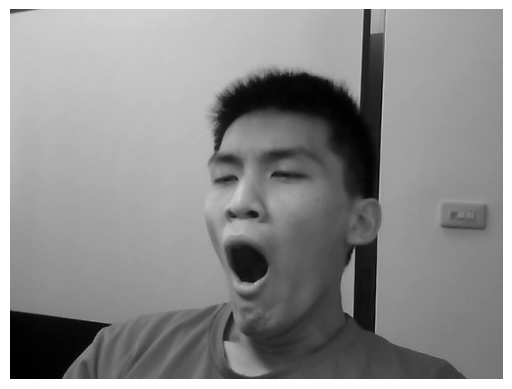

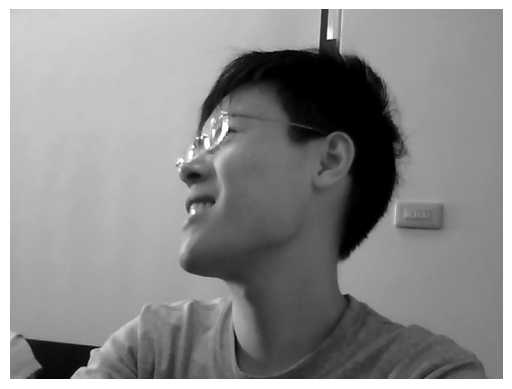

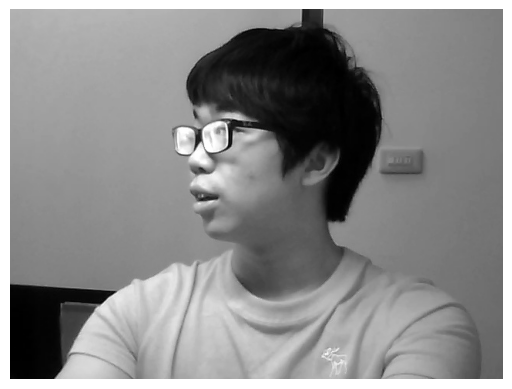

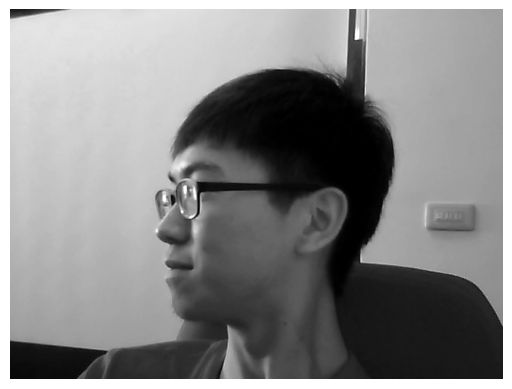

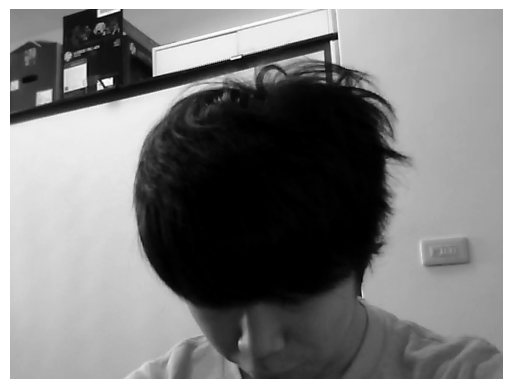

In [98]:
train_error_files = pd.read_csv("./train-error_files.csv")
# Ambil sampel acak 10 baris dari DataFrame
train_error_files = df.sample(n=5, random_state=42)  # Anda bisa ganti nilai random_state sesuai kebutuhan

# Loop melalui setiap baris di sampel dan tampilkan gambar
for path in train_error_files['file_path']:
    img = read_image(path)
    display_image(img)

# C. Train

In [136]:
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.models import model_from_json

In [111]:
# Load the data
file_path = './train-nthuddd.csv'
train_df = pd.read_csv(file_path)

# Drop unnecessary columns
train_df = train_df.drop(columns=['img_name', 'img_path'])
train_df.head()

,label,mar_1,ear_1,mar_2,ear_2,mar_3,ear_3,mar_4,ear_4,mar_5,...,mar_56,ear_56,mar_57,ear_57,mar_58,ear_58,mar_59,ear_59,mar_60,ear_60
0,drowsy,0.057861,0.493654,0.060569,0.493199,0.057185,0.494126,0.048953,0.510086,0.040342,...,0.049619,0.510140,0.049752,0.504838,0.053209,0.513384,0.056853,0.523008,0.040930,0.499053
1,drowsy,0.058819,0.509362,0.062165,0.512073,0.058044,0.517976,0.057185,0.523544,0.048253,...,0.040988,0.514570,0.041656,0.513614,0.058132,0.511658,0.066436,0.522789,0.063307,0.523939
2,drowsy,0.049752,0.493278,0.062986,0.510183,0.058024,0.478331,0.041036,0.484672,0.041745,...,0.056334,0.501868,0.048179,0.497923,0.048308,0.513156,0.048221,0.505971,0.051620,0.508975
3,drowsy,0.053323,0.508443,0.048953,0.506755,0.049885,0.518815,0.065433,0.506438,0.067709,...,0.447234,0.500075,0.386112,0.506756,0.317190,0.517013,0.245818,0.518242,0.233061,0.528098
4,drowsy,0.203362,0.497319,0.200909,0.518481,0.142127,0.512868,0.133473,0.496957,0.140898,...,0.036171,0.482390,0.029827,0.478358,0.030235,0.500856,0.043999,0.486827,0.030083,0.476525


In [112]:
# Encode the labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
train_df.head()

,label,mar_1,ear_1,mar_2,ear_2,mar_3,ear_3,mar_4,ear_4,mar_5,...,mar_56,ear_56,mar_57,ear_57,mar_58,ear_58,mar_59,ear_59,mar_60,ear_60
0,0,0.057861,0.493654,0.060569,0.493199,0.057185,0.494126,0.048953,0.510086,0.040342,...,0.049619,0.510140,0.049752,0.504838,0.053209,0.513384,0.056853,0.523008,0.040930,0.499053
1,0,0.058819,0.509362,0.062165,0.512073,0.058044,0.517976,0.057185,0.523544,0.048253,...,0.040988,0.514570,0.041656,0.513614,0.058132,0.511658,0.066436,0.522789,0.063307,0.523939
2,0,0.049752,0.493278,0.062986,0.510183,0.058024,0.478331,0.041036,0.484672,0.041745,...,0.056334,0.501868,0.048179,0.497923,0.048308,0.513156,0.048221,0.505971,0.051620,0.508975
3,0,0.053323,0.508443,0.048953,0.506755,0.049885,0.518815,0.065433,0.506438,0.067709,...,0.447234,0.500075,0.386112,0.506756,0.317190,0.517013,0.245818,0.518242,0.233061,0.528098
4,0,0.203362,0.497319,0.200909,0.518481,0.142127,0.512868,0.133473,0.496957,0.140898,...,0.036171,0.482390,0.029827,0.478358,0.030235,0.500856,0.043999,0.486827,0.030083,0.476525


In [120]:
# Separate features and labels
X = train_df.drop(columns=['label']).values  # Convert to numpy array for model input
y = train_df['label'].values

# Reshape X to 3D (samples, timesteps, features) for LSTM
X = X.reshape((X.shape[0], 60, 2))  # Assuming we have 60 timesteps with 2 features (MAR, EAR)
# X = X.reshape((X.shape[0], 120, 1)) #Get val acc 57% stuck

# One-hot encode the labels for classification
y = to_categorical(y)

# Split the train_df into training and validation sets (90% train, 10% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [121]:
#  Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(50, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
28/28 [==============================] - 1s 18ms/step - loss: 0.6918 - accuracy: 0.5393 - val_loss: 0.6860 - val_accuracy: 0.5714
Epoch 2/20
28/28 [==============================] - 0s 10ms/step - loss: 0.6911 - accuracy: 0.5405 - val_loss: 0.6835 - val_accuracy: 0.5714
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.6881 - accuracy: 0.5405 - val_loss: 0.6695 - val_accuracy: 0.5714
Epoch 4/20
28/28 [==============================] - 0s 10ms/step - loss: 0.6847 - accuracy: 0.5382 - val_loss: 0.6855 - val_accuracy: 0.5510
Epoch 5/20
28/28 [==============================] - 0s 9ms/step - loss: 0.6813 - accuracy: 0.5462 - val_loss: 0.6511 - val_accuracy: 0.6531
Epoch 6/20
28/28 [==============================] - 0s 10ms/step - loss: 0.6727 - accuracy: 0.5610 - val_loss: 0.6407 - val_accuracy: 0.5408
Epoch 7/20
28/28 [==============================] - 0s 10ms/step - loss: 0.6769 - accuracy: 0.5222 - val_loss: 0.6408 - val_accuracy: 0.5714
Epoch 8/20
28/

In [122]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

4/4 [==============================] - 0s 4ms/step - loss: 0.5911 - accuracy: 0.6735
Validation Loss: 0.5911386609077454, Validation Accuracy: 0.6734693646430969


In [137]:
def save_model_as_pkl(model, filepath):
    # Save the model's architecture and weights separately
    model_json = model.to_json()
    weights = model.get_weights()
    
    # Save as a dictionary in a .pkl file
    with open(filepath, 'wb') as f:
        pickle.dump({'model_json': model_json, 'weights': weights}, f)
    print(f"Model saved to {filepath}")

def load_model_from_pkl(filepath):
    # Load the dictionary from the .pkl file
    with open(filepath, 'rb') as f:
        model_data = pickle.load(f)
    
    # Recreate the model architecture
    model = model_from_json(model_data['model_json'])
    
    # Load weights into the model
    model.set_weights(model_data['weights'])
    print("Model loaded from .pkl file")
    
    return model

In [138]:
save_model_as_pkl(model, 'lstm_model.pkl')

Model saved to lstm_model.pkl


In [141]:
def evaluate_model_on_test(test_file_path, model_file_path):
    # Load the model from .pkl file
    model = load_model_from_pkl(model_file_path)
    
    # Load the test dataset
    test_data = pd.read_csv(test_file_path)
    test_data = test_data.drop(columns=['img_name', 'img_path'])
    # Separate features and true labels
    X_test = test_data.drop(columns=['label']).values  # Drop the label column, keep only features
    y_true = test_data['label'].values  # True labels for evaluation

    # Encode true labels to match model's predicted output
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(y_true)

    # Preprocess the test features to the same shape as the training data
    X_test = X_test.reshape((X_test.shape[0], 60, 2))  # Reshape to (samples, timesteps, features)

    # Make predictions
    predictions = model.predict(X_test)
    
    # Get predicted labels
    predicted_labels = predictions.argmax(axis=1)
    
    # Decode predicted labels back to original label names
    predicted_classes = label_encoder.inverse_transform(predicted_labels)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true_encoded, predicted_labels, target_names=label_encoder.classes_))
    
    # Optionally return a DataFrame with true and predicted labels
    results = pd.DataFrame({'True Label': y_true, 'Predicted Label': predicted_classes})
    return results

In [142]:
test_results = evaluate_model_on_test('./test-nthuddd.csv', './lstm_model.pkl')

Model loaded from .pkl file
4/4 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

      drowsy       0.67      0.48      0.56        58
   notdrowsy       0.54      0.71      0.61        49

    accuracy                           0.59       107
   macro avg       0.60      0.60      0.59       107
weighted avg       0.61      0.59      0.58       107



# D. Create Report